The EDEX modelsounding plugin creates 64-level vertical profiles from GFS and ETA (NAM) model runs. As of AWIPS release 16.1.5, the available locations are limited to stations around OAX (Omaha) due to localization (16.2.2 will allow requests for all stations).

In [37]:
from awips.dataaccess import DataAccessLayer
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("modelsounding")
request.addIdentifier("reportType", "ETA")
request.setParameters("pressure","temperature","specHum","uComp","vComp")

In [38]:
availableLocs = DataAccessLayer.getAvailableLocationNames(request)
availableLocs.sort()
for loc in availableLocs: print loc

CHE
CRL
EAX
HSI
KDSM
KFOE
KFRM
KFSD
KGRI
KLNK
KMCI
KMCW
KMHE
KMHK
KMKC
KOFK
KOMA
KRSL
KSLN
KSTJ
KSUX
KTOP
KYKN
OAX
P#8
P#9
P#A
P#G
P#I
RDD
WSC


In [39]:
request.setLocationNames("WSC")

In [40]:
cycles = DataAccessLayer.getAvailableTimes(request, True)
print "using ", str(cycles[-1]) # 0 for FIRST time, -1 for LAST

using  2016-07-15 00:00:00


In [41]:
allTimes = DataAccessLayer.getAvailableTimes(request)

# Build one complete model run
fcstRun = []
for time in allTimes:
    if str(time)[:19] == str(cycles[-1]):
        fcstRun.append(time)

#for time in fcstRun: print time

## Request data for a single time

In [42]:
response = DataAccessLayer.getGeometryData(request,times=[fcstRun[0]])

In [43]:
print "parms    = " + str(response[0].getParameters())
print "site     = " + response[0].getLocationName()
print "datetime = " + str(response[0].getDataTime())
print "geom     = " + str(response[0].getGeometry())
print ""

print fcstRun[0]

tmp,prs,sh,uc,vc = [],[],[],[],[]
for ob in response:
    tmp.append(float(ob.getString("temperature")))
    prs.append(float(ob.getString("pressure")))
    sh.append(float(ob.getString("specHum")))
    uc.append(float(ob.getString("uComp")))
    vc.append(float(ob.getString("vComp")))

parms    = ['pressure', 'uComp', 'temperature', 'specHum', 'vComp']
site     = WSC
datetime = 1970-01-17 23:55:40.800000 (0)
geom     = POINT (-93.55999755859375 44.13999938964844)

2016-07-15 00:00:00 (0)


## Create data arrays and calculate dewpoint from spec. humidity

In [44]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import exp, log
import numpy as np

from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile, dewpoint
from metpy.calc import get_wind_speed,get_wind_dir, thermo, vapor_pressure
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

pres = np.array(prs)
# we can use units.* here...
t = (np.array(tmp)-273.16) * units.degC
p = np.array(pres)/100 * units.mbar
s = np.array(sh)

u,v = np.array(uc)*1.94384,np.array(vc)*1.94384 # m/s to knots
spd = get_wind_speed(u, v) * units.knots
dir = get_wind_dir(u, v) * units.deg


## Dewpoint from Specific Humidity

Because the modelsounding plugin does not return dewpoint values, we must calculate the profile ourselves.  Here are three examples of dewpoint calculated from specific humidity, including a manual calculation following NCEP AWIPS/NSHARP. 

### 1) metpy calculated mixing ratio and vapor pressure

In [45]:
rmix = (s/(1-s)) *1000 * units('g/kg')
e = vapor_pressure(p, rmix)
td = dewpoint(e)

### 2) metpy calculated assuming spec. humidity = mixing ratio

In [46]:
td2 = dewpoint(vapor_pressure(p, s))

### 3) NCEP AWIPS soundingrequest plugin
based on GEMPAK/NSHARP, from https://github.com/Unidata/awips2-ncep/blob/unidata_16.2.2/edex/gov.noaa.nws.ncep.edex.plugin.soundingrequest/src/gov/noaa/nws/ncep/edex/plugin/soundingrequest/handler/MergeSounding.java#L1783

In [47]:
# new arrays
ntmp,nprs,nsh = np.array(tmp)-273.16,np.array(prs),np.array(sh)

# where p=pressure(pa), T=temp(C), T0=reference temp(273.16)
rh = 0.263*nprs*nsh / (np.exp(17.67*ntmp/(ntmp+273.16-29.65)))
vaps =  6.112 * np.exp((17.67 * ntmp) / (ntmp + 243.5))
vapr = rh * vaps / 100
dwpc = np.array(243.5 * (np.log(6.112) - np.log(vapr)) / (np.log(vapr) - np.log(6.112) - 17.67)) * units.degC

/awips2/python/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/awips2/python/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


In [48]:
print min(td), max(td)
print min(td2), max(td2)
print min(dwpc), max(dwpc)

-92.478017542 degC 13.9116676363 degC
-92.4780705498 degC 13.7561341768 degC
-92.4797373828 degC 14.0048053654 degC


## Plot with MetPy

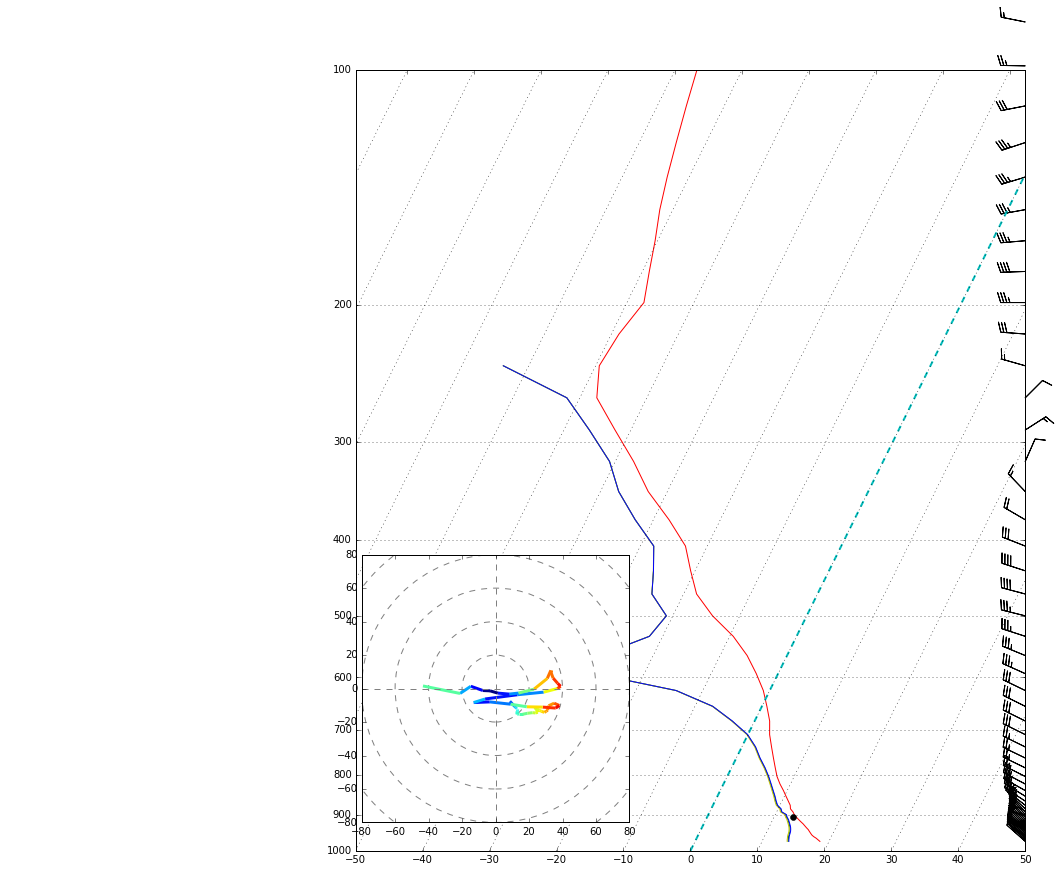

In [49]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 14)

# Create a skewT plot
skew = SkewT()

# Plot the data
skew.plot(p, t, 'r')
skew.plot(p, td, 'g')
skew.plot(p, td2, 'y')
skew.plot(p, dwpc, 'b')

skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot
l = lcl(p[0], t[0], td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), t[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=3)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()

In [50]:
# manually inspect the three calculated dewpoint profiles
for i in range(0,len(p)):
    print p[i], td[i], td2[i], dwpc[i]

972.6 millibar 13.9116676363 degC 13.7561341768 degC 14.0048053654 degC
968.1 millibar 13.795309995 degC 13.6403678572 degC 13.8880708933 degC
963.5 millibar 13.7070447902 degC 13.5523590688 degC 13.7996354037 degC
958.9 millibar 13.6034524052 degC 13.4491913275 degC 13.6957654641 degC
954.2 millibar 13.5430001542 degC 13.3886616121 degC 13.6353487333 degC
949.4 millibar 13.4955511833 degC 13.3409697537 degC 13.5880407718 degC
944.6 millibar 13.4327262238 degC 13.2780704887 degC 13.5252528231 degC
939.6 millibar 13.3214175505 degC 13.1671951789 degC 13.4136681067 degC
934.5 millibar 13.1780826854 degC 13.0246305994 degC 13.2698459052 degC
929.1 millibar 12.9840646965 degC 12.8318898986 degC 13.0750280636 degC
923.7 millibar 12.7587117079 degC 12.6081461774 degC 12.8486706315 degC
917.9 millibar 12.5100387601 degC 12.3612538202 degC 12.5988843283 degC
911.9 millibar 12.2408903895 degC 12.094052447 degC 12.3285202779 degC
905.6 millibar 11.8707829848 degC 11.7268890509 degC 11.956583349 